# Project 3: Web APIs & NLP

### By Alex Lau

## 1. Table of Contents

1. [Table of Contents](#1.-Table-of-Contents)
2. [Loading Libraries](#2.-Loading-Libraries)
3. [Web Scraping/Data Collection](#3.-Web-Scraping/Data-Collection)
4. [Exploratory Data Analysis (EDA)](#4.-Exploratory-Data-Analysis-(EDA))
5. [Data Cleaning](#5.-Data-Cleaning)
6. [Model Preperation (Preprocessing)](#6.-Model-Preparation-(Preprocessing))
7. [Modeling](#7.-Modeling)
    <br>7.1 [Baseline Model](#7.1-Baseline-Model)
    <br>7.2 [Count Vectorized Logistic Regression](#7.2-Count-Vectorized-Logistic-Regression)
    <br>7.3 [TF-IDF Vectorized Logistic Regression](#7.3-TFIDF-Vectorized-Logistic-Regression)
    <br>7.4 [Multinomial Naive Bayes Classifier](#7.4-Multinomial-Naive-Bayes-Classifier)
    <br>7.5 [Gaussian Naive Bayes Classifier](#7.5-Gaussian-Naive-Bayes-Classifier)
8. [Model Selection](#8.-Model-Selection)
9. [Model Evaluation](#9.-Model-Evaluation)
10. [Conclusions and Evaluation](#10.-Conclusions-and-Evaluation)

## 2. Loading Libraries & Data

In [1]:
# Import libaries
import pandas as pd
import numpy as np
import requests
import datetime as dt
import time
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns

from string import ascii_uppercase
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from nltk import word_tokenize, ngrams
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.base import TransformerMixin

## 3. Web Scraping/Data Collection

We define a function below to engage with the reddit website and pull the content based on subreddit topics that we will feed in. We are requesting content from the last 150 days to gather a large enough dataset to generate significant results. We are also delaying each iteration by 2 seconds to ensure we do not overload the server. 

In [2]:
# we're asking pushshift to engage with redit website
def query_pushshift(subreddit, kind='submission', skip=30, times=5, # we are pulling 30 days of posts 5 times = 150 days
                    subfield = ['title', 'selftext', 'subreddit', 'created_utc', 'author', 'num_comments', 
                                'score', 'is_self'], #
                    comfields = ['body', 'score', 'created_utc']):
    stem = "https://api.pushshift.io/reddit/search/{}/?subreddit={}&size=500".format(kind, subreddit)
    
    mylist = []
    
    for x in range(1, times + 1):
        
        URL = "{}&after={}d".format(stem, skip * x)
        print(URL)
        response = requests.get(URL)
        assert response.status_code == 200
        mine = response.json()['data']
        df = pd.DataFrame.from_dict(mine)
        mylist.append(df)
        time.sleep(2) # We will wait 2 seconds each iteration to prevent overloading the server
        
    full = pd.concat(mylist, sort=False)
    
    if kind == "submission":
        
        full = full[subfield]
        
        full = full.drop_duplicates()
        
        full = full.loc[full['is_self'] == True]
        
    def get_date(created):
        return dt.date.fromtimestamp(created)
    
    _timestamp = full["created_utc"].apply(get_date)
    
    full['timestamp'] = _timestamp
    print(full.shape)
    
    return full 

We are running our query push shift functions on our 2 reddit topics below, directly related to our problem statement.

In [3]:
sub_1_query = query_pushshift('teslamotors')

https://api.pushshift.io/reddit/search/submission/?subreddit=teslamotors&size=500&after=30d
https://api.pushshift.io/reddit/search/submission/?subreddit=teslamotors&size=500&after=60d
https://api.pushshift.io/reddit/search/submission/?subreddit=teslamotors&size=500&after=90d
https://api.pushshift.io/reddit/search/submission/?subreddit=teslamotors&size=500&after=120d
https://api.pushshift.io/reddit/search/submission/?subreddit=teslamotors&size=500&after=150d
(1313, 9)


In [4]:
sub_2_query = query_pushshift('cars')

https://api.pushshift.io/reddit/search/submission/?subreddit=cars&size=500&after=30d
https://api.pushshift.io/reddit/search/submission/?subreddit=cars&size=500&after=60d
https://api.pushshift.io/reddit/search/submission/?subreddit=cars&size=500&after=90d
https://api.pushshift.io/reddit/search/submission/?subreddit=cars&size=500&after=120d
https://api.pushshift.io/reddit/search/submission/?subreddit=cars&size=500&after=150d
(1634, 9)


We are combining the content from both subreddits into a single dataframe below

In [5]:
combined_sub_queries = pd.concat([sub_1_query, sub_2_query])

## 4. Exploratory Data Analysis (EDA)

In [6]:
# getting the length of columns and rows
combined_sub_queries.shape

(2947, 9)

In [7]:
# Identifying the data types for all columns
combined_sub_queries.dtypes

title           object
selftext        object
subreddit       object
created_utc      int64
author          object
num_comments     int64
score            int64
is_self           bool
timestamp       object
dtype: object

In [8]:
# Viewing the first 5 rows
combined_sub_queries.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,"FSD wording changed to ""coming later this year""",Looks like as the clock rolls over to 2020 tha...,teslamotors,1577865335,mahkus11,3,1,True,2020-01-01
2,Feature Request: battery preconditioning drivi...,Here in Europe we have many other fast chargin...,teslamotors,1577867595,sharpfoam,62,1,True,2020-01-01
3,My favorite Tesla hack to date!,https://imgur.com/gallery/1kgf4WF\n\nUsing a f...,teslamotors,1577867764,godloki,67,1,True,2020-01-01
4,"It’s Q1, where is my model Y?",[removed],teslamotors,1577868924,code_name_duchess_18,0,1,True,2020-01-01
5,Anyone concerned about model Y Pricing,"For those that purchased the first Model 3s, t...",teslamotors,1577868984,I_Shit_Gold_Bars,0,1,True,2020-01-01


In [9]:
# Viewing the last 5 rows
combined_sub_queries.tail()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
493,Price for a matte paint job or wrap?,I don’t know much about cars but I was wonderi...,cars,1567668656,basedwatts250,7,1,True,2019-09-05
494,Don't you hate when you see a car from one bra...,[removed],cars,1567671007,young_legendary,2,1,True,2019-09-05
495,Why do we use larger rear tires for hard accel...,Looking at cars and motorcycles(this is actual...,cars,1567674235,LMGDiVa,5,0,True,2019-09-05
498,Shillong Tour Packages,[removed],cars,1567677088,travenjo,0,1,True,2019-09-05
499,"I want to purchase a car used for family, the ...",[removed],cars,1567677421,cocola-full2,2,1,True,2019-09-05


In [10]:
# Reviewing the statistics of the columns, only limited to 3 numeric columns
combined_sub_queries.describe()

,created_utc,num_comments,score
count,2.947000e+03,2947.000000,2947.000000
mean,1.572914e+09,22.685443,15.862572
std,3.665619e+06,90.778487,157.871881
min,1.567499e+09,0.000000,0.000000
25%,1.570161e+09,0.000000,1.000000
50%,1.572872e+09,2.000000,1.000000
75%,1.575501e+09,16.000000,1.000000
max,1.578242e+09,2962.000000,5222.000000


There are missing self-text values.

In [11]:
# idenfifying missing values
combined_sub_queries.isnull().sum()

title            0
selftext        41
subreddit        0
created_utc      0
author           0
num_comments     0
score            0
is_self          0
timestamp        0
dtype: int64

In [57]:
# Viewing the posts without self-texts
combined_sub_queries[combined_sub_queries['selftext']=='[removed]']

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
4,"It’s Q1, where is my model Y?",[removed],teslamotors,1577868924,code_name_duchess_18,0,1,True,2020-01-01
11,FSD in Europe,[removed],teslamotors,1577876752,Sebbikul,0,1,True,2020-01-01
12,"Tesla Model Y in Charlotte, NC",[removed],teslamotors,1577878008,PikeForPresident,0,1,True,2020-01-01
14,Anyone else notice the Upgrades section is mis...,[removed],teslamotors,1577879613,pmv2018,0,1,True,2020-01-01
15,Third eye,[removed],teslamotors,1577880250,jpteslalove,0,1,True,2020-01-01
...,...,...,...,...,...,...,...,...,...
484,Delhi to Agra Cabs,[removed],cars,1567666392,travenjo,0,1,True,2019-09-05
488,Do I need to press the clutch down all the way...,[removed],cars,1567667473,7sidedleaf,2,1,True,2019-09-05
494,Don't you hate when you see a car from one bra...,[removed],cars,1567671007,young_legendary,2,1,True,2019-09-05
498,Shillong Tour Packages,[removed],cars,1567677088,travenjo,0,1,True,2019-09-05


1310 or over 44% of posts have had their self-texts removed and a small portion do not have any values populated in this column. We will be focusing on the titles columns instead.

In [13]:
# viewing documents where sefttext was removed.
combined_sub_queries.head(20)

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,"FSD wording changed to ""coming later this year""",Looks like as the clock rolls over to 2020 tha...,teslamotors,1577865335,mahkus11,3,1,True,2020-01-01
2,Feature Request: battery preconditioning drivi...,Here in Europe we have many other fast chargin...,teslamotors,1577867595,sharpfoam,62,1,True,2020-01-01
3,My favorite Tesla hack to date!,https://imgur.com/gallery/1kgf4WF\n\nUsing a f...,teslamotors,1577867764,godloki,67,1,True,2020-01-01
4,"It’s Q1, where is my model Y?",[removed],teslamotors,1577868924,code_name_duchess_18,0,1,True,2020-01-01
5,Anyone concerned about model Y Pricing,"For those that purchased the first Model 3s, t...",teslamotors,1577868984,I_Shit_Gold_Bars,0,1,True,2020-01-01
6,Daily Discussion + Support Thread - January 01,"Use this recurring thread for basic Q&amp;A, v...",teslamotors,1577869893,AutoModerator,179,1,True,2020-01-01
11,FSD in Europe,[removed],teslamotors,1577876752,Sebbikul,0,1,True,2020-01-01
12,"Tesla Model Y in Charlotte, NC",[removed],teslamotors,1577878008,PikeForPresident,0,1,True,2020-01-01
13,Postponing delivery of M3P.,My delivery is estimated to be ready by around...,teslamotors,1577879407,eklitz,6,1,True,2020-01-01
14,Anyone else notice the Upgrades section is mis...,[removed],teslamotors,1577879613,pmv2018,0,1,True,2020-01-01


In [14]:
combined_sub_queries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2947 entries, 0 to 499
Data columns (total 9 columns):
title           2947 non-null object
selftext        2906 non-null object
subreddit       2947 non-null object
created_utc     2947 non-null int64
author          2947 non-null object
num_comments    2947 non-null int64
score           2947 non-null int64
is_self         2947 non-null bool
timestamp       2947 non-null object
dtypes: bool(1), int64(3), object(5)
memory usage: 210.1+ KB


It seems people are slightly more engaging on subreddit 'teslamotors' given the higher mean number of comments. 

In [16]:
# identifying the mean values for each subreddit
combined_sub_queries.groupby('subreddit').mean()

,created_utc,num_comments,score,is_self
subreddit,,,,
cars,1.572793e+09,21.921665,16.282742,True
teslamotors,1.573065e+09,23.635948,15.339680,True


In [17]:
# function for displaying bar graph of frequent terms based on the subreddit
def frequent_terms(subreddit, ngrams):
    cv = CountVectorizer(stop_words = 'english', ngram_range=ngrams)
    cv.fit(combined_sub_queries.loc[combined_sub_queries['subreddit'] == subreddit,'title'])
    X_cv = cv.transform(combined_sub_queries.loc[combined_sub_queries['subreddit'] == subreddit,'title'])
    X_cv_df = pd.DataFrame(X_cv.todense(), columns=cv.get_feature_names())
    bar_graph = X_cv_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh')
    plt.title(f'Most Frequent Terms in "{subreddit}"', size = 16)
    plt.xlabel('Frequency', size = 15)
    plt.ylabel('Words', size = 15)
    return bar_graph

Top 20 titles from subreddit "cars" unsurprisingly contains the word "car" many times. We can also derive that the most popular car of discussion is Honda Civic, followed by Ford Mustang, Toyota Camry, Land Rover Range Rover, and Toyota Corolla. We can also see more interest in new cars as opposed to used cars.

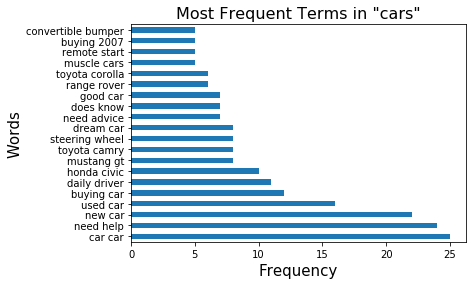

In [18]:
frequent_terms('cars', (2,2));

The most popular term in the "teslamotors" subreddit, "feature request", refers to over-the-air (OTA) software updates that Tesla sends out over time. These are mostly wish lists, and sometimes do come true when Tesla reviews feedback. Owners will frequently tweet Elon Musk, and he will respond! The 3rd most populate bigram is "smart summon" which refers to the feature of using phones to control the car to drive forward, backward, or even navigate to where you are in a parking lot. 
<br>We would expect low occurances of these terms in the 'cars' subreddit since most other auto manufacturers are not as software focused, and are lagging behind in this area. 
<br>We also see frequent occurances of the term "daily discussion" and "support thread" which we will need to take out since that is a general reddit term and not subreddit specific. 
<br>Given the high level of Tesla specific terms, we are confident in our ability to accuratly match titles to their respective subreddits.

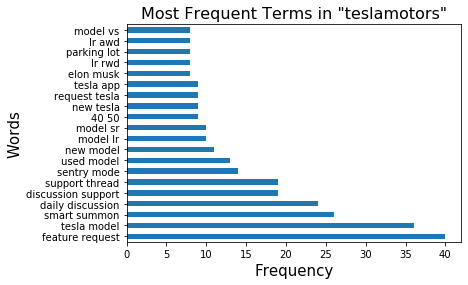

In [19]:
frequent_terms('teslamotors', (2,2));

In [20]:
# Split data up into X and y.
X = combined_sub_queries['title']
y = combined_sub_queries['subreddit'].map(lambda x: 1 if x == 'teslamotors' else 0)

cv = CountVectorizer(stop_words = 'english')
cv.fit(X)
X_cv = cv.transform(X)
words = pd.DataFrame(X_cv.todense(), columns=cv.get_feature_names())

# Let's look at the most frequently used words.
words.sum().sort_values(ascending=False).head(20)

car           564
tesla         392
model         300
new           143
cars          136
help          100
does          100
question       94
need           78
vs             70
just           69
used           67
buy            60
know           60
request        57
feature        57
cybertruck     56
driving        56
looking        54
advice         54
dtype: int64

In [21]:
# checking the number of words
words.sum()

00         3
000       13
000rpm     1
01         2
02         6
          ..
zero       2
zipcar     1
zonda      1
zones      1
zx4        1
Length: 4605, dtype: int64

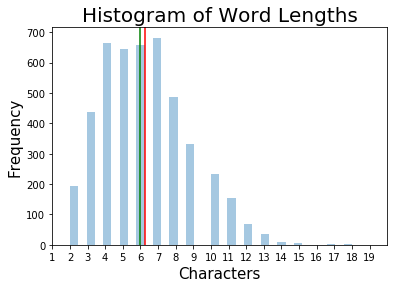

In [22]:
# Plot the character lengths of the words.
lengths_of_words = [len(each) for each in words.columns]
fig, ax = plt.subplots()
sns.distplot(lengths_of_words, ax=ax, kde = False)
plt.title('Histogram of Word Lengths', size = 20)
plt.axvline(np.mean(lengths_of_words), 0,350, color = 'red')
plt.axvline(np.median(lengths_of_words), 0,350, color = 'green')
plt.ylabel('Frequency', size = 15)
plt.xlabel('Characters', size = 15)
ax.set_xlim(1,20)
ax.set_xticks(range(1,20))
plt.show();

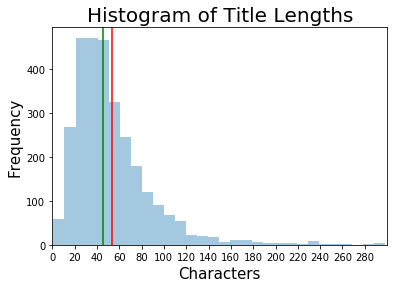

In [23]:
# Plot the character lengths of the titles.
lengths_of_posts = [len(each) for each in X]
fig, ax = plt.subplots()
sns.distplot(lengths_of_posts, kde = False, bins = 30) #kde = False
plt.title('Histogram of Title Lengths', size = 20)
plt.axvline(np.mean(lengths_of_posts), 0,350, color = 'red')
plt.axvline(np.median(lengths_of_posts), 0,350, color = 'green')
plt.ylabel('Frequency', size = 15)
plt.xlabel('Characters', size = 15)
ax.set_xlim(1,300)
ax.set_xticks(range(0, 300, 20))
plt.show();

In [24]:
# identifying the mean character lenght of titles
np.mean(lengths_of_posts)

53.13369528333899

In [25]:
# identifying the median character lenght of titles
np.median(lengths_of_posts)

45.0

In [26]:
# Checking the quantities of each class to confirm they are balanced
combined_sub_queries['subreddit'].value_counts()

cars           1634
teslamotors    1313
Name: subreddit, dtype: int64

## 5. Data Cleaning

In [27]:
combined_sub_queries

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,"FSD wording changed to ""coming later this year""",Looks like as the clock rolls over to 2020 tha...,teslamotors,1577865335,mahkus11,3,1,True,2020-01-01
2,Feature Request: battery preconditioning drivi...,Here in Europe we have many other fast chargin...,teslamotors,1577867595,sharpfoam,62,1,True,2020-01-01
3,My favorite Tesla hack to date!,https://imgur.com/gallery/1kgf4WF\n\nUsing a f...,teslamotors,1577867764,godloki,67,1,True,2020-01-01
4,"It’s Q1, where is my model Y?",[removed],teslamotors,1577868924,code_name_duchess_18,0,1,True,2020-01-01
5,Anyone concerned about model Y Pricing,"For those that purchased the first Model 3s, t...",teslamotors,1577868984,I_Shit_Gold_Bars,0,1,True,2020-01-01
...,...,...,...,...,...,...,...,...,...
493,Price for a matte paint job or wrap?,I don’t know much about cars but I was wonderi...,cars,1567668656,basedwatts250,7,1,True,2019-09-05
494,Don't you hate when you see a car from one bra...,[removed],cars,1567671007,young_legendary,2,1,True,2019-09-05
495,Why do we use larger rear tires for hard accel...,Looking at cars and motorcycles(this is actual...,cars,1567674235,LMGDiVa,5,0,True,2019-09-05
498,Shillong Tour Packages,[removed],cars,1567677088,travenjo,0,1,True,2019-09-05


In [28]:
# removing any potential duplicates
combined_sub_queries = combined_sub_queries.drop_duplicates()

In [29]:
# Viewing how balanced the data set is between the two classes
combined_sub_queries['subreddit'].value_counts()

cars           1634
teslamotors    1313
Name: subreddit, dtype: int64

We have setup stop words to remove the 'daily discussion' and 'support thread' in our model preparation section, which will run during our modeling section.

## 6. Model Preparation (Preprocessing)

In [30]:
# Setting up our X and y variables
X = combined_sub_queries['title']
y = combined_sub_queries['subreddit']

# train test splitting our data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [31]:
# setting up our classes to use later in our pipelines
# following code found on https://scikit-learn.org/stable/modules/feature_extraction.html
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    
class StemTokenizer:
    def __init__(self):
        self.stemmer = PorterStemmer()
    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in word_tokenize(doc)]

# https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required/51127115#51127115
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [32]:
# setting up custom stop words
sw = ['daily discussion', 'support thread']

## 7. Modeling

### 7.1 Baseline Model

Our baseline is 55.45%. This represents the majority class of subreddit 'cars' of our binary classification problem. We need to outperform this majority baseline score before we can claim usefulness from our models. 

In [33]:
baseline = y.value_counts(normalize = True).max()
baseline

0.5544621649134713

### 7.2 Count Vectorized Logistic Regression

Count Vectorizer is a transformer that tokenizes text by lowercasing and removing punctuation from words. It does not, however, convert the words to their root forms. We have introduced Porter Stemmer and WordNet Lemmatizer as a hyper-parameter in all of our models. Stemming may result in words that are not actual English words, but lemmatizing will root to actual English words. 
Logistic Regression is a linear where predictions are transformed using logistic function. There is a default penalty of L2, meaning this will automatically use the Ridge penalty and lower coefficients instead of removing them completely. We have included hyper parameters 'lbfgs', 'liblinear', and 'saga' and will have the model determine the best to use. 

In [34]:
# Instantiate pipeline.  
pipe_cv = Pipeline([
    ('cv', CountVectorizer(stop_words = sw)), 
    ('lr', LogisticRegression())
])

# Define grid of parameters to GridSearch over.
params_grid = {
    'cv__tokenizer': [LemmaTokenizer(), StemTokenizer()],
    'cv__max_features': [3950, 4000, 4050],
    'cv__stop_words': ['english'],
    'cv__ngram_range': [(1,7),(1,8)],
    'lr__solver': ['lbfgs', 'liblinear', 'saga']
}

# GridSearch over pipeline with given grid of parameters.
gs_cv = GridSearchCV(pipe_cv, params_grid, cv=5, scoring = 'accuracy')

# Fit model.
gs_cv.fit(X_train, y_train)

gs_cv.best_estimator_

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'so

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'so

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'so

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

Pipeline(memory=None,
         steps=[('cv',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=4000, min_df=1,
                                 ngram_range=(1, 8), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<__main__.StemTokenizer object at 0x0000014810B1DB48>,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
           

In [35]:
gs_cv.best_params_

{'cv__max_features': 4000,
 'cv__ngram_range': (1, 8),
 'cv__stop_words': 'english',
 'cv__tokenizer': <__main__.StemTokenizer at 0x14810b1db48>,
 'lr__solver': 'liblinear'}

In [36]:
# checking accuracy score
gs_cv_lr_accuracy = np.round(gs_cv.score(X_test, y_test), 4)
gs_cv_lr_accuracy

0.8752

### 7.3 TFIDF Vectorized Logistic Regression

Term frequency inverse document frequency (TF-IDF) Vectorizer is another tranformer that offers a more sophisticated approach as it builds on Count Vectorizer by increasing weights on words that are frequent in a document or row, but offsets this by decreasing weights on words that are frequent in the corpus, or the number of documents that contain the words in question. 

In [37]:
# Define Pipeline - TFIDF
pipe_tfidf = Pipeline(steps = [('tfidfvec', TfidfVectorizer(stop_words = sw)),     # first tuple is for first step: vectorizer
                         ('lr', LogisticRegression())        # second tuple is for second step: model
                        ])    

# Construct Grid Parameters
hyperparams_grid = {
                'tfidfvec__tokenizer': [LemmaTokenizer(), StemTokenizer()],
                'tfidfvec__max_features': [4050, 4100, 4150],
                'tfidfvec__ngram_range': [(1,4),(1,5),(1,6)],
                'tfidfvec__stop_words': ['english'],
                'lr__solver': ['liblinear', 'lbfgs', 'saga']
}

# Perform Grid Search
gs_tfidf = GridSearchCV(pipe_tfidf, # pipeline object replaces what we usually had as empty model class
                 param_grid=hyperparams_grid,
                 cv = 5,
                 scoring = 'accuracy')

gs_tfidf.fit(X_train, y_train)

# Get best estimator
gs_tfidf.best_estimator_

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

Pipeline(memory=None,
         steps=[('tfidfvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=4150,
                                 min_df=1, ngram_range=(1, 5), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_p...,
                                 tokenizer=<__main__.StemTokenizer object at 0x0000014814DF8608>,
                                 use_idf=True, vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_

In [39]:
# checking accuracy score
gs_tfidf_lr_accuracy = np.round(gs_tfidf.score(X_test, y_test),4)
gs_tfidf_lr_accuracy

0.8657

### 7.4 Multinomial Naive Bayes Classifier

Mutlinomial Naive Bayes works when we have discrete data, building on Count Vectorizer using the counts of each word or token to classify and predict our y value.

In [40]:
# setup pipeline for Multinomial Naive Bayes
pipe_mnb = Pipeline([
     ('cvec', CountVectorizer(stop_words = sw)), 
     ('to_dense', DenseTransformer()), 
     ('mnb', MultinomialNB())
])

# Construct Grid Parameters
hyperparams_grid = {
                'cvec__tokenizer': [LemmaTokenizer(), StemTokenizer()],
                'cvec__max_features': [5000, 5500],
                'cvec__ngram_range': [(1,6),(1,7)],
                'cvec__stop_words': ['english'],
                'mnb__alpha': [0, 0.5, 1]
}

# Perform Grid Search
gs_mnb = GridSearchCV(pipe_mnb, # pipeline object replaces what we usually had as empty model class
                 param_grid=hyperparams_grid,
                 cv = 5,
                 scoring = 'accuracy')

gs_mnb.fit(X_train, y_train)

# Get best estimator
gs_mnb.best_estimator_

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in st

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=5000, min_df=1,
                                 ngram_range=(1, 6), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<__main__.LemmaTokenizer object at 0x0000014810B1AB08>,
                                 vocabulary=None)),
                ('to_dense',
                 <__main__.DenseTransformer object at 0x0000014815301C88>),
                ('mnb',
                 MultinomialNB(alpha=1, class_prior=None, fit_prior=True))],
         verbose=False)

In [41]:
gs_mnb.best_params_

{'cvec__max_features': 5000,
 'cvec__ngram_range': (1, 6),
 'cvec__stop_words': 'english',
 'cvec__tokenizer': <__main__.LemmaTokenizer at 0x14810b1ab08>,
 'mnb__alpha': 1}

In [42]:
# checking accuracy score
gs_mnb_accuracy = np.round(gs_mnb.score(X_test, y_test), 4)
gs_mnb_accuracy

0.867

### 7.5 Gaussian Naive Bayes Classifier####

Gaussian Naive Bayes is used in cases where our features are continuous, hence we will combine this with our TF-IDF Vectorizer. A Gaussian distributions is also called a normal distribtuion, providing a bell shaped curve symmetric about the mean of the feature values.

In [43]:
# setup pipeline for Multinomial Naive Bayes
pipe_gnb = Pipeline([
     ('tfidfvec', TfidfVectorizer(stop_words = sw)), 
     ('to_dense', DenseTransformer()), 
     ('gnb', GaussianNB())
])

# Construct Grid Parameters
hyperparams_grid = {
                'tfidfvec__tokenizer': [LemmaTokenizer(), StemTokenizer()],
                'tfidfvec__max_features': [5000, 5500, 6000],
                'tfidfvec__ngram_range': [(1,7), (1,8)],
                'tfidfvec__stop_words': ['english'],
                'gnb__var_smoothing': [0.7, 0.8, 0.9]
}

# Perform Grid Search
gs_gnb = GridSearchCV(pipe_gnb, # pipeline object replaces what we usually had as empty model class
                 param_grid=hyperparams_grid,
                 cv = 5,
                 scoring = 'accuracy')

gs_gnb.fit(X_train, y_train)

# Get best estimator
gs_gnb.best_estimator_

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Pipeline(memory=None,
         steps=[('tfidfvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=5000,
                                 min_df=1, ngram_range=(1, 8), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<__main__.LemmaTokenizer object at 0x00000148159DFB48>,
                                 use_idf=True, vocabulary=None)),
                ('to_dense',
                 <__main__.DenseTransformer object at 0x0000014814E88088>),
        

In [44]:
gs_gnb.best_params_

{'gnb__var_smoothing': 0.9,
 'tfidfvec__max_features': 5000,
 'tfidfvec__ngram_range': (1, 8),
 'tfidfvec__stop_words': 'english',
 'tfidfvec__tokenizer': <__main__.LemmaTokenizer at 0x148159dfb48>}

In [45]:
# checking accuracy score
gs_gnb_accuracy = np.round(gs_gnb.score(X_test, y_test), 4)
gs_gnb_accuracy

0.8589

In [46]:
# Evaluate predictions
print(f'Baseline accuracy score is : {np.round(baseline, 4)}.')
print()
print(f'Training accuracy score for our Count Vectorized Logistic Regression model is: {round(gs_cv.score(X_train, y_train),4)}.')
print(f'Testing accuracy score for our Count Vectorized Logistic Regression model is: {gs_cv_lr_accuracy}.')
print()
print(f'Training accuracy score for our TF-IDF Vectorized Logistic Regression model is: {round(gs_tfidf.score(X_train, y_train),4)}.')
print(f'Testing accuracy score for our TF-IDF Vectorized Logistic Regression model is: {gs_tfidf_lr_accuracy}.')
print()
print(f'Training accuracy score for our Multinomial Naive Bayes Classifier model is: {round(gs_mnb.score(X_train, y_train),4)}.')
print(f'Testing accuracy score for our Multinomial Naive Bayes Classifier model is: {gs_mnb_accuracy}.')
print()
print(f'Training accuracy score for our Gaussian Naive Bayes model is: {round(gs_gnb.score(X_train, y_train),4)}.')
print(f'Testing accuracy score for our Gaussian Naive Bayes model is: {gs_gnb_accuracy}.')

Baseline accuracy score is : 0.5545.

Training accuracy score for our Count Vectorized Logistic Regression model is: 0.9624.
Testing accuracy score for our Count Vectorized Logistic Regression model is: 0.8752.

Training accuracy score for our TF-IDF Vectorized Logistic Regression model is: 0.9376.
Testing accuracy score for our TF-IDF Vectorized Logistic Regression model is: 0.8657.

Training accuracy score for our Multinomial Naive Bayes Classifier model is: 0.9439.
Testing accuracy score for our Multinomial Naive Bayes Classifier model is: 0.867.

Training accuracy score for our Gaussian Naive Bayes model is: 0.9434.
Testing accuracy score for our Gaussian Naive Bayes model is: 0.8589.


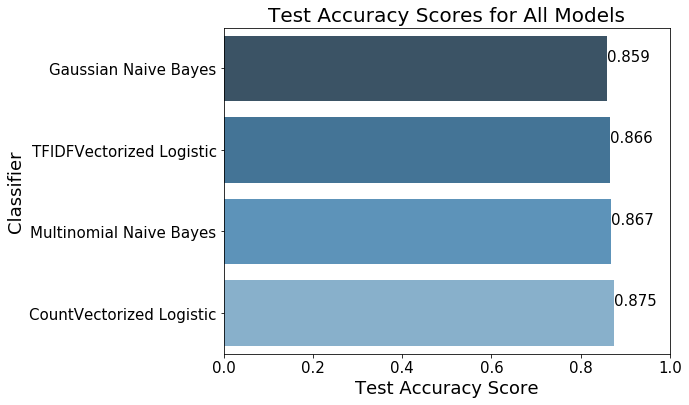

In [47]:
# initialize list of lists 
scores_list = [['CountVectorized Logistic', gs_cv_lr_accuracy], ['TFIDFVectorized Logistic', gs_tfidf_lr_accuracy], 
        ['Multinomial Naive Bayes', gs_mnb_accuracy], ['Gaussian Naive Bayes', gs_gnb_accuracy]]
  
# Create the pandas DataFrame 
scores_df = pd.DataFrame(scores_list, columns = ['Classifier', 'Test Accuracy Score']).sort_values('Test Accuracy Score')
# scores_df.sort_values(scores_df, ascending = False)

plt.figure(figsize = (8, 6))
ax = sns.barplot(x="Test Accuracy Score", y='Classifier', data=scores_df, palette = 'Blues_d')
plt.title(f'Test Accuracy Scores for All Models', size = 20)
plt.xlabel('Test Accuracy Score', size = 18)
plt.xticks(ticks = [0, 0.2, 0.4, 0.6, 0.8, 1], size = 15)
plt.yticks(size = 15)
plt.ylabel('Classifier', size = 18)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width(), i.get_y()+.31, \
            str(round((i.get_width()), 3)), fontsize=15, color='black')

## 8. Model Selection

Our best model appears to be the Count Vectorized Logistic Regression Model with an testing accuracy score of 87.52%, so we will select this to evaluate. This is 32 points above our baseline of 55.45 %, or nearly 58% increase. We ran multiple iterations of our models and found that as titles of posts changed over time, our winning model would switch between TFIDF Vectorized Logistic regression and Multinomial Naive Bayes, but we never had an instance of the Gaussian Naive Bayes scoring highest. 

## 9. Model Evaluation

Below we are getting our best model, the 2nd value of our grid search from Count Vectorized Logistic Regression model, and our best transformer, the 1st value. This will allow us to call dot(.) attributes and methods to eventually pull our coefficients, which will help us identify the most useful words for our model to predict the subreddit 'teslamotors'. 

In [48]:
best_model = gs_cv.best_estimator_[1]
best_transformer = gs_cv.best_estimator_[0]

In [49]:
features = best_transformer.get_feature_names()

In [50]:
coefs = best_model.coef_[0]

In [51]:
coef_df = pd.DataFrame({
    'feature':features,
    'coef': np.round(coefs, 2),
    'exp_coef': np.round(np.exp(coefs), 2)
})

The exp_coef below represents the odds that a title is classified as under subreddit 'teslamotors' given the word in the feature column exists in the document. It is not surprising that given a document contains the word "tesla" it is 76.87 times as likely to be classified under 'teslamotors'. Terms beyond the obvious make and model include autopilot: a driver assistance safety feature with automatic emergency braking, V10: Tesla's biggest software version update, and summon: functionality to move your car from your phone like a remote control. 

In [52]:
coef_df.sort_values(by = 'coef', ascending = False).head(20)

,feature,coef,exp_coef
3417,tesla,4.34,76.87
1354,cybertruck,2.88,17.84
879,autopilot,2.17,8.79
3767,v10,1.90,6.69
2380,model,1.87,6.52
2243,m3,1.83,6.24
3322,summon,1.82,6.17
2376,mode,1.65,5.19
1616,elon,1.63,5.11
1429,deliveri,1.59,4.93


Below we have mapped a confusion matrix of the actual subreddit vs our predictions. We were better at accurately predicting titles that belonged in the cars subreddit than teslamotors. We were 97.3 % accurate with our predictions from actual subreddit 'cars', but only 75.3% accurate with our predictions from actual subreddit 'teslamotors'. This means there are still normal car terms used in subreddit 'teslamotors' that our model was unable to differentiate between the two, but this is expected. 

In [53]:
y_pred = gs_cv.predict(X_test)

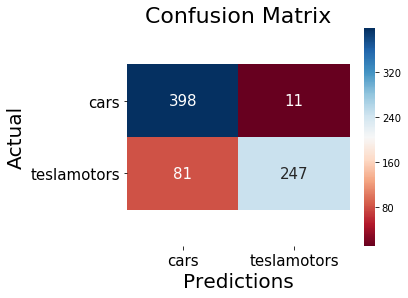

In [54]:
confm = confusion_matrix(y_test, y_pred)
columns = ['cars', 'teslamotors'] # need to fix this
df_cm = pd.DataFrame(confm, index=columns, columns=columns)
# sns.heatmap(df_cm, cmap='Oranges', annot=True)
plt.figure(figsize = (5, 4))
plt.title('Confusion Matrix', size = 22)
sns.heatmap(df_cm, annot=True, fmt = 'd', annot_kws={"size": 15}, cmap = 'RdBu')
plt.ylabel('Actual', size = 20)
plt.xlabel('Predictions', size = 20)
plt.yticks(rotation = 0, size = 15)
plt.xticks(size = 15)

# shoutout to SalMac86 on https://github.com/mwaskom/seaborn/issues/1773
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

## add xlabel and ylabel for predicted vs actual

In [55]:
# confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [56]:
# additional metrics
print('Accuracy:',  round((tp + tn) / (tp+fp+tn+fn), 4))
print('Recall/Sensitivity:', round((tp) / (tp+fn), 4))
print('Specificity:', round((tn) / (tn+fp), 4))
print('Precision:', round((tp) / (tp+fp), 4))

Accuracy: 0.8752
Recall/Sensitivity: 0.753
Specificity: 0.9731
Precision: 0.9574


## 10. Conclusions and Evaluation

All of our models were more successful than the baseline in classifying the subreddit, but our Count Vectorized Logistic Model outperformed the rest with an accuracy score of 87.5%. We are successful in building a model that can reasonably classify a title of a reddit post to belonging to subreddit 'teslamotors' or 'cars'. We were also successfull in identifying key words beyond the make and model that hold significance, such as autopilot, v10, and summon. Tesla spends $0 on advertising, so it is not surprising if the population is not familiar with these features in relation to vehicles. If we can educate the public on new technologies that exist on Tesla vehicles, specifically context behind the highest non-make and model coefficients of our model from subreddit 'teslamotors', we can potentially reduce the dependency on gas, slow down global warming and pollution, and save some lives with autopilot.